In [1]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
import json
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns

idx = pd.IndexSlice

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## LOAD RANDOM SEARCH DATA

### Load v3

In [2]:
rs_ver = "rs_v3"
base_path = f"data/ronin/{rs_ver}"

In [3]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'rep', 'it', 'route_id'])
    return df

In [4]:

def make_df(path: str, shift_rep=0):

    # DATA FROM PATH
    data = {}
    data['path'] = path
    stem = Path(path).stem.split("_")
    data['fps'] = int(stem[1])
    data['highquality'] = stem[3]
    match path.split("/"):
        case ["data", "ronin", _, rep, "checkpoints", it, *objects]:
            data['rep'] = int(rep) + shift_rep
            data['it'] = int(it[2:])
    # print(data)

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_df(df)


dfs = []
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file))

dfv3 = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]

dfv3.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1500 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 9, 24, 'RouteScenario_735')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    1500 non-null   float64
 1   duration_system  1500 non-null   float64
dtypes: float64(2)
memory usage: 55.1+ KB


^ should be 1500 = 25 iter x 10 rep x 2 quality x 3 fps values

### Load v4
and shift repetition number +10

In [5]:
dfs = []
base_path = f"data/ronin/rs_v4"
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file, shift_rep=10))

dfv4 = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]
dfv4.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000 entries, (10, 'False', 10, 0, 'RouteScenario_358') to (20, 'True', 29, 24, 'RouteScenario_319')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    3000 non-null   float64
 1   duration_system  3000 non-null   float64
dtypes: float64(2)
memory usage: 88.3+ KB


### Concatonate v3 and v4

In [6]:
df = pd.concat([dfv3, dfv4]).sort_index()
# df = pd.concat([dfv3]).sort_index()
n_reps = df.reset_index()['rep'].nunique()
print(f"Currently we have {n_reps} repetitions")
df.info()

Currently we have 30 repetitions
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4500 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 29, 24, 'RouteScenario_319')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    4500 non-null   float64
 1   duration_system  4500 non-null   float64
dtypes: float64(2)
memory usage: 121.2+ KB


## LOAD VERIFICATION DATA

In [7]:
def process_verification_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['route_id'])
    return df


def make_verification_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_verification_df(df)

In [8]:
dfs = []
base_path = f"data/ronin/rs_v3"
pattern = f"{base_path}/verification/checkpoints/*/*.json"
for file in glob.glob(pattern):
    # print(file)
    dfs.append(make_verification_df(file))

oracle_df = pd.concat(dfs).sort_index()[['driving_score']]
oracle_df = oracle_df.rename(columns={"driving_score": "oracle_dscore"})
oracle_df

,oracle_dscore
route_id,
RouteScenario_0,0.65
RouteScenario_1,0.65
RouteScenario_10,1.00
RouteScenario_100,1.00
RouteScenario_101,0.70
...,...
RouteScenario_95,1.00
RouteScenario_96,1.00
RouteScenario_97,1.00


## PROCESS SOLUTIONS

In [9]:


def get_solutions_of_iteration(curr_it):

    # get slice of data frame from iteration 0 to current iteration
    slice = df.loc[idx[:, :, :, :curr_it+1], :]

    # get index of minumum driving score -> solution
    solutions_idx = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score'].idxmin().rename('solution_idx')

    # get value of minimum driving score
    solutions_score = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score'].min().rename('solution_score')

    solutions = pd.concat([solutions_idx, solutions_score], axis=1)
    solutions['it'] = curr_it
    solutions = solutions.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it'])

    return solutions

In [10]:
# get_solutions_of_iteration(5)

In [11]:
NUM_OF_ITERAITON = 25

sols_df = pd.concat([get_solutions_of_iteration(it)
                    for it in range(NUM_OF_ITERAITON)], axis=0)

# at what iteration did we find the solution
sols_df['solution_it'] = sols_df['solution_idx'].apply(lambda x: x[-2])
# what is the route_id of the solution
sols_df['solution_route_id'] = sols_df['solution_idx'].apply(lambda x: x[-1])

# we don't need that once unpacked
sols_df = sols_df.drop('solution_idx', axis=1)

# add data from verification
sols_df = sols_df.join(oracle_df, on='solution_route_id')
sols_df = sols_df.sort_index()
sols_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4500 entries, (10, 'False', 0, 0) to (20, 'True', 29, 24)
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   solution_score     4500 non-null   float64
 1   solution_it        4500 non-null   int64  
 2   solution_route_id  4500 non-null   object 
 3   oracle_dscore      4500 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 160.7+ KB


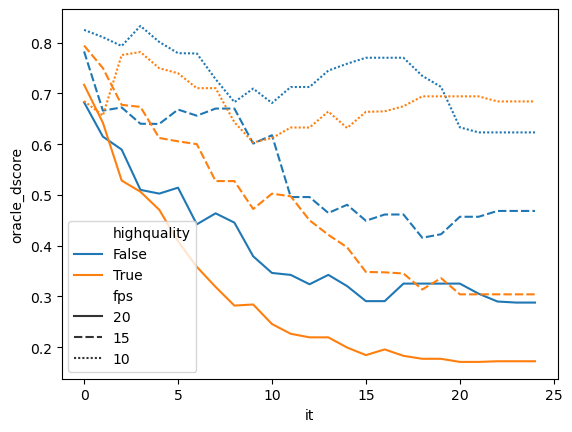

In [12]:
f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

ax = sns.lineplot(data=sols_df, x='it', y='oracle_dscore', style_order=[20, 15, 10],
                  style='fps', hue='highquality', ax=ax, errorbar=None)

In [13]:
cumulative_time = df.groupby(['fps', 'highquality', 'rep'])[
    'duration_system'].cumsum()
cumulative_time = cumulative_time.rename(
    'cumulative_time').to_frame().droplevel('route_id')

sols_df = sols_df.join(cumulative_time)

In [14]:
sols_df

solution_score  solution_it  solution_route_id  oracle_dscore  cumulative_time
fps highquality rep it                                                                                
10  False       0   0         0.096086            1  RouteScenario_461       0.700000       514.576038
                    1         0.055417            2    RouteScenario_4       1.000000      1225.405219
                    2         0.055417            2    RouteScenario_4       1.000000      1737.925832
                    3         0.055417            2    RouteScenario_4       1.000000      2002.960191
                    4         0.055417            2    RouteScenario_4       1.000000      2627.114673
...                                ...          ...                ...            ...              ...
20  True        29  20        0.183873           15  RouteScenario_245       0.169976     15520.832104
                    21        0.183873           15  RouteScenario_245       0.169976     16203.806252
                    22        0.183873           15  RouteScenario_245       0.169976     17401.625561
                    23        0.183873           15  RouteScenario_245       0.169976     18293.066054
                    24        0.183873           15  RouteScenario_245       0.169976     18608.288639

[4500 rows x 5 columns]

In [15]:
# aggregate mean across repetitions so it can be ploted nicely
data = sols_df[['oracle_dscore', 'cumulative_time', 'solution_score']
               ].groupby(['fps', 'highquality', 'it']).mean()

# data

In [16]:
data.index = data.index.set_levels(data.index.levels[0].astype(str), level=0)
data = data.sort_index(ascending=False)
data.head()

oracle_dscore  cumulative_time  solution_score
fps highquality it                                                
20  True        24       0.172194     17489.776885        0.131139
                23       0.172194     16986.821854        0.131139
                22       0.172194     16403.120337        0.131139
                21       0.170862     15680.510756        0.139559
                20       0.170862     14913.436740        0.139559

## PLOT Oracle DScore

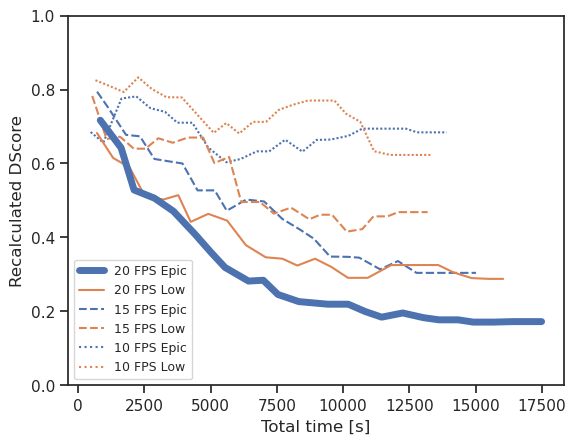

In [17]:
sns.set_theme(style="ticks", palette="deep")

f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

sns.lineplot(data=data, x='cumulative_time', y='oracle_dscore',
             style='fps', hue='highquality', ax=ax, errorbar=None)

sns.lineplot(data=data.xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
             y='oracle_dscore', hue='highquality', ax=ax,  errorbar=None, lw=5)


ax.set_ylabel("Recalculated DScore")
ax.set_xlabel("Total time [s]")
ax.set_ylim(0, 1)

# BETTER LEGEND
handles, labels = ax.get_legend_handles_labels()

blue = handles[1].get_color()
orange = handles[2].get_color()
lines = [
    mlines.Line2D([], [], color=blue, linestyle=None,
                  label='20 FPS Epic', lw=5),
    mlines.Line2D([], [], color=orange, linestyle=None, label='20 FPS Low'),

    mlines.Line2D([], [], color=blue, linestyle='--', label='15 FPS Epic'),
    mlines.Line2D([], [], color=orange, linestyle='--', label='15 FPS Low'),
    mlines.Line2D([], [], color=blue, linestyle='dotted',
                  label='10 FPS Epic'),
    mlines.Line2D([], [], color=orange,
                  linestyle='dotted', label='10 FPS Low'),

]

ax.legend(handles=lines, prop={'size': 9})

f.savefig('rq3.pdf', bbox_inches='tight')

## PLOT low-fid Dscore

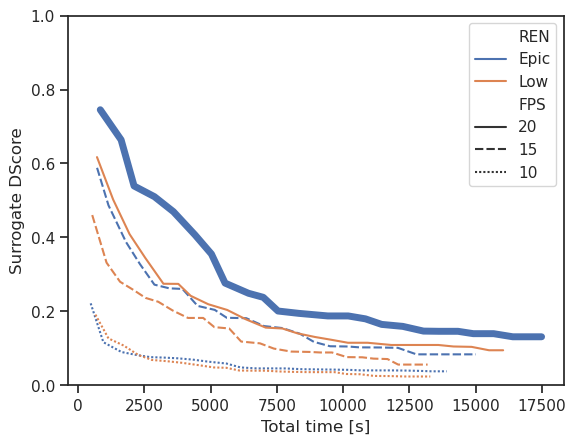

In [18]:
sns.set_theme(style="ticks", palette="deep")

f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

sns.lineplot(data=data, x='cumulative_time', y='solution_score',
             style='fps', hue='highquality', ax=ax, errorbar=None)

sns.lineplot(data=data.xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
             y='solution_score', hue='highquality', ax=ax,  errorbar=None, lw=5)


ax.set_ylabel("Surrogate DScore")
ax.set_xlabel("Total time [s]")
ax.set_ylim(0, 1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[
          'REN', 'Epic', 'Low', 'FPS', '20', '15', '10'])

## Statistical tests

In [36]:
from scipy.stats import mannwhitneyu
from itertools import permutations

ITERATION = 0

In [37]:


def do_test(fid_a, fid_b, set_a, set_b, confidence_level=0.95):
    U1, p = mannwhitneyu(set_a, set_b)

    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\tAt {ITERATION = } the difference beetween {fid_a} and {fid_b} IS statistically significant. {p = :.5f}")
        print(set_a)
        print(set_b)
    else:
        # return
        print(
            f"\tAt {ITERATION = } the difference beetween {fid_a} and {fid_b} is NOT statistically significant. {p = :.5f}")

In [38]:
#
oracle_dscores = sols_df.loc[idx[:, :, :, ITERATION]]['oracle_dscore'].groupby(
    ['fps', 'highquality',]).agg(list)

In [39]:
# iterate over all possible fidelities
for (a_fid, a_list), (b_fid, b_list) in permutations(oracle_dscores.items(), 2):
    do_test(a_fid, b_fid, a_list, b_list)

	At ITERATION = 0 the difference beetween (10, 'False') and (10, 'True') is NOT statistically significant. p = 0.28931
	At ITERATION = 0 the difference beetween (10, 'False') and (15, 'False') is NOT statistically significant. p = 0.93418
	At ITERATION = 0 the difference beetween (10, 'False') and (15, 'True') is NOT statistically significant. p = 0.93417
	At ITERATION = 0 the difference beetween (10, 'False') and (20, 'False') is NOT statistically significant. p = 0.05741
	At ITERATION = 0 the difference beetween (10, 'False') and (20, 'True') is NOT statistically significant. p = 0.10978
	At ITERATION = 0 the difference beetween (10, 'True') and (10, 'False') is NOT statistically significant. p = 0.28931
	At ITERATION = 0 the difference beetween (10, 'True') and (15, 'False') is NOT statistically significant. p = 0.36445
	At ITERATION = 0 the difference beetween (10, 'True') and (15, 'True') is NOT statistically significant. p = 0.26042
	At ITERATION = 0 the difference beetween (10, 

## Total time

In [40]:
n_rows = df['duration_system'].index.size
n_rows

4500

In [41]:
total_hours = df['duration_system'].sum() / 3600
total_hours

741.0766619208124

In [42]:
n_rows / total_hours

6.0722462752184825